Authors: Hofmarcher, Dinu, Radler

Date: 23-03-2021

---

This file is part of the "Deep Reinforcement Learning" lecture material. The following copyright statement applies to all code within this file.

Copyright statement:
This material, no matter whether in printed or electronic form, may be used for personal and non-commercial educational use only. Any reproduction of this manuscript, no matter whether as a whole or in parts, no matter whether in printed or in electronic form, requires explicit prior acceptance of the authors.

## Enable GPU Acceleration

---
Before you start exploring this notebook make sure that GPU support is enabled.
To enable the GPU backend for your notebook, go to **Edit** → **Notebook Settings** and set **Hardware accelerator** to **GPU**. 

---


# Imports

Install OpenAI Gym and dependencies to render the environments

In [ ]:
!apt update
!apt install -y xvfb x11-utils python-opengl ffmpeg 
!pip install gym==0.17.3 pyvirtualdisplay 
!pip install box2d-py
!pip install gym[box2d]
!pip install onnx onnx2pytorch

In [1]:
%matplotlib inline

import os
import math
import glob
import io
import base64
import random
import numpy as np
from time import time, strftime
from tqdm.notebook import tqdm

# PyTorch imports
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.distributions import Categorical
from torchvision.transforms import Compose

# ONNX
import onnx
from onnx2pytorch import ConvertModel

# Environment import and set logger level to display error only
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only

# Plotting and notebook imports
import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns; sns.set()
from IPython.display import HTML, clear_output
from IPython import display

# start virtual display
from pyvirtualdisplay import Display
pydisplay = Display(visible=0, size=(640, 480))
pydisplay.start()

# Setup Google Drive mount to store your results

In [ ]:
mount_google_drive = False
if mount_google_drive:
    from google.colab import drive
    drive.mount('/content/drive')

# Download Dataset

In [ ]:
!wget --no-check-certificate 'https://cloud.ml.jku.at/s/9KRoE8s9c6WccDL/download' -O train.npz
!wget --no-check-certificate 'https://cloud.ml.jku.at/s/Dx2Bgy5Sb6R8xTw/download' -O val.npz
!wget --no-check-certificate 'https://cloud.ml.jku.at/s/26Hpzm3q2WgfRi8/download' -O expert.onnx

# Auxiliary Methods

In [2]:
class Logger():
    def __init__(self, logdir, params=None):
        self.basepath = os.path.join(logdir, strftime("%Y-%m-%dT%H-%M-%S"))
        os.makedirs(self.basepath, exist_ok=True)
        os.makedirs(self.log_dir, exist_ok=True)
        if params is not None and os.path.exists(params):
            shutil.copyfile(params, os.path.join(self.basepath, "params.pkl"))
        self.log_dict = {}
        self.dump_idx = {}

    @property
    def param_file(self):
        return os.path.join(self.basepath, "params.pkl")

    @property
    def onnx_file(self):
        return os.path.join(self.basepath, "model.onnx")

    @property
    def log_dir(self):
        return os.path.join(self.basepath, "logs")

    def log(self, name, value):
        if name not in self.log_dict:
            self.log_dict[name] = []
            self.dump_idx[name] = -1
        self.log_dict[name].append((len(self.log_dict[name]), time(), value))
    
    def get_values(self, name):
        if name in self.log_dict:
            return [x[2] for x in self.log_dict[name]]
        return None
    
    def dump(self):
        for name, rows in self.log_dict.items():
            with open(os.path.join(self.log_dir, name + ".log"), "a") as f:
                for i, row in enumerate(rows):
                    if i > self.dump_idx[name]:
                        f.write(",".join([str(x) for x in row]) + "\n")
                        self.dump_idx[name] = i


def plot_metrics(logger):
    train_loss  = logger.get_values("training_loss")
    train_entropy  = logger.get_values("training_entropy")
    val_loss = logger.get_values("validation_loss")
    val_acc = logger.get_values("validation_accuracy")
    
    fig = plt.figure(figsize=(15,5))
    ax1 = fig.add_subplot(131, label="train")
    ax2 = fig.add_subplot(131, label="val",frame_on=False)
    ax4 = fig.add_subplot(132, label="entropy")
    ax3 = fig.add_subplot(133, label="acc")

    ax1.plot(train_loss, color="C0")
    ax1.set_ylabel("Loss")
    ax1.set_xlabel("Update (Training)", color="C0")        
    ax1.xaxis.grid(False)  
    ax1.set_ylim((0,4))

    ax2.plot(val_loss, color="C1")
    ax2.xaxis.tick_top()
    ax2.yaxis.tick_right()
    ax2.set_xlabel('Epoch (Validation)', color="C1")     
    ax2.xaxis.set_label_position('top')     
    ax2.xaxis.grid(False)
    ax2.get_yaxis().set_visible(False)
    ax2.set_ylim((0,4))

    ax4.plot(train_entropy, color="C3")    
    ax4.set_xlabel('Update (Training)', color="black")     
    ax4.set_ylabel("Entropy", color="C3")
    ax4.tick_params(axis='x', colors="black")
    ax4.tick_params(axis='y', colors="black")
    ax4.xaxis.grid(False)

    ax3.plot(val_acc, color="C2")
    ax3.set_xlabel("Epoch (Validation)", color="black")
    ax3.set_ylabel("Accuracy", color="C2")
    ax3.tick_params(axis='x', colors="black")
    ax3.tick_params(axis='y', colors="black")
    ax3.xaxis.grid(False)
    ax3.set_ylim((0,1))

    fig.tight_layout(pad=2.0)
    plt.show()
    
                    
def print_action(dataset, action):
    action = dataset.action_mapping[action]
    print("Left %.1f" % action[0] if action[0] < 0 else "Right %.1f" %
          action[0] if action[0] > 0 else "Straight")
    print("Throttle %.1f" % action[1])
    print("Break %.1f" % action[2])

"""
Utility functions to enable video recording of gym environment and displaying it
"""
def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay 
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                 </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")
    

def wrap_env(env):
    env = Monitor(env, './video', force=True)
    return env

# Convert RBG image to grayscale and normalize by data statistics
def rgb2gray(rgb, norm=True):    
    # rgb image -> gray [0, 1]
    gray = np.dot(rgb[..., :], [0.299, 0.587, 0.114])
    if norm:
        # normalize
        gray = gray / 128. - 1.
    return gray

def hide_hud(img):
    img[84:] = 0
    return img

def save_as_onnx(torch_model, sample_input, model_path):
    torch.onnx.export(torch_model,             # model being run
                    sample_input,              # model input (or a tuple for multiple inputs)
                    f=model_path,              # where to save the model (can be a file or file-like object)
                    export_params=True,        # store the trained parameter weights inside the model file
                    opset_version=13,          # the ONNX version to export the model to - see https://github.com/microsoft/onnxruntime/blob/master/docs/Versioning.md
                    do_constant_folding=True,  # whether to execute constant folding for optimization
                    )

# Dataloader

In [3]:
class DemonstrationDataset(Dataset):
    def __init__(self, data_file, img_stack=1, show_hud=True):
        assert (os.path.exists(data_file))
        self.data = np.load(data_file)
        self.frames = self.data["frames"]
        self.actions = self.data["actions"]
        self.img_stack = img_stack
        
        if show_hud:
            self.transforms = Compose([rgb2gray])
        else:
            self.transforms = Compose([hide_hud, rgb2gray])

        # Action space (map from continuous actions for steering, throttle and break to 25 action combinations)
        action_mapping = [
            (0, 0, 0),  # no action
            (0, 0.5, 0),  # half throttle
            (0, 1, 0),  # full trottle
            (0, 0, 0.5),  # half break
            (0, 0, 1),  # full break
            # steering left with throttle/break control
            (-0.5, 0, 0),  # half left
            (-1, 0, 0),  # full left
            (-0.5, 0.5, 0),  # half left
            (-1, 0.5, 0),  # full left
            (-0.5, 1, 0),  # half left
            (-1, 1, 0),  # full left
            (-0.5, 0, 0.5),  # half left
            (-1, 0, 0.5),  # full left
            (-0.5, 0, 1),  # half left
            (-1, 0, 1),  # full left
            # steering right with throttle/break control
            (0.5, 0, 0),  # half right
            (1, 0, 0),  # full right
            (0.5, 0.5, 0),  # half right
            (1, 0.5, 0),  # full right
            (0.5, 1, 0),  # half right
            (1, 1, 0),  # full right
            (0.5, 0, 0.5),  # half right
            (1, 0, 0.5),  # full right
            (0.5, 0, 1),  # half right
            (1, 0, 1)  # full right
        ]

        self.action_mapping = {i: x for i, x in enumerate(action_mapping)}             
        self.act_to_idx = {x: i for i, x in enumerate(action_mapping)}             

    def __len__(self):
        return self.frames.shape[0] - self.img_stack

    def __getitem__(self, idx):
        frames, action = self.frames[idx:idx + self.img_stack], self.actions[
            idx + self.img_stack - 1]
        transformed = []
        for i in range(len(frames)):
            transformed.append(self.transforms(frames[i]))
        transformed = np.stack(transformed, axis=0)
        return transformed, self.act_to_idx[tuple(action)]

    def append(self, frame, action):
        self.frames = np.append(self.frames, frame, axis=0)
        self.actions = np.append(self.actions, action, axis=0)

# Inspect data

Number of samples: 156964


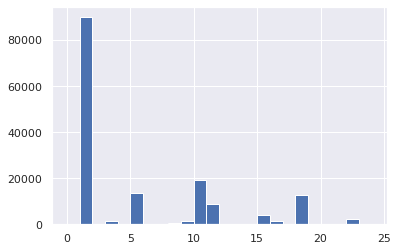

In [4]:
# Action Statistics
dataset = DemonstrationDataset("./data/train.npz")
print("Number of samples: {}".format(len(dataset)))
act_to_idx = {v: k for k, v in dataset.action_mapping.items()}
plt.hist([act_to_idx[tuple(action)] for action in dataset.actions], bins=list(range(25)));

Action: 1
Straight
Throttle 0.5
Break 0.0


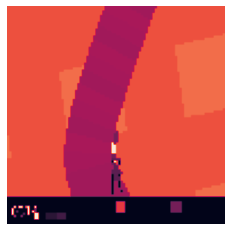

In [5]:
# Visualize random frames
idx = np.random.randint(len(dataset))
frame, action = dataset[idx]
print("Action: {}".format(action))
print_action(dataset, action)
plt.axis("off")
plt.imshow(dataset[idx][0][0]);

In [6]:
# release memory
del dataset

# Define Policy Network

In [7]:
class AgentNetwork(nn.Module):
    def __init__(self,
                 n_units_out,
                 hidden_size=512,
                 num_feature_maps=32,
                 kernel_size=6,
                 activation=nn.LeakyReLU()
                 ):
        super(AgentNetwork, self).__init__()

        ########################
        #### YOUR CODE HERE ####
        ########################
        # Note: the input to the network is one grayscale
        # The dimension of the frames is 96x96
        # Hence, the input tensor has shape [1, 96, 96]

        # Note 2: don't apply an activation function to the output layer
        # Our loss function implicitly applies the softmax activation
        # which is numerically more stable

        num_inputs, input_width, _ = (1, 96, 96)

        self.cnn_layer1 = nn.Conv2d(num_inputs, num_feature_maps, kernel_size, stride=4, padding=0)
        self.cnn_layer2 = nn.Conv2d(num_feature_maps, num_feature_maps * 2, int(kernel_size / 2), stride=2, padding=0)
        self.cnn_layer3 = nn.Conv2d(num_feature_maps * 2, num_feature_maps, int(kernel_size / 2), stride=1, padding=0)

        feature_map_for_linear_layer = self.calculate_next_feature_map_size(
            [self.cnn_layer1, self.cnn_layer2, self.cnn_layer3], input_width
        )
        assert feature_map_for_linear_layer >= 1, f"Ouch! the layer 3 feature is of size {feature_map_for_linear_layer}"

        self.linear_layer = nn.Linear(num_feature_maps * feature_map_for_linear_layer ** 2, hidden_size)
        self.activation = activation

        self.output_layer = nn.Linear(hidden_size, n_units_out)

    def forward(self, x):
        ########################
        #### YOUR CODE HERE ####
        ########################
        # Process the batch with your defined network and
        # return action predictions

        x = self.activation(self.cnn_layer1(x))
        x = self.activation(self.cnn_layer2(x))
        x = self.activation(self.cnn_layer3(x))
        x = x.view(-1, x.shape[1:].numel())
        x = self.activation(self.linear_layer(x))

        return self.output_layer(x)
    
    def calculate_next_feature_map_size(self, layers: list, feature_map_size: int):
        """ Initially the feature_map_size is the width of the input """
        for layer in layers:
            padding = layer.padding[0]
            stride = layer.stride[0]
            kernel = layer.kernel_size[0]
            feature_map_size = (feature_map_size - kernel + 2 * padding) / stride + 1
        return int(feature_map_size)

# Define Training and Validation Routines

In [8]:
def train(net, loader, loss_func, optimizer, logger, epoch):
    net.train()    
    running_loss = None
    alpha = 0.3
    with tqdm(loader, desc="[%03d] Loss: %.4f" % (epoch, 0.)) as pbar:
        for frame, action in pbar:
            frame = frame.float().to(device)
            action = action.to(device)
            # prediction
            prediction = net(frame)                       
            # loss
            loss = loss_func(prediction, action)
            # entropy
            with torch.no_grad():
                probs = torch.softmax(prediction, dim=-1)
                entropy = torch.mean(-torch.sum(probs * torch.log(probs), dim=-1)) 
            # Update weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # log
            logger.log("training_loss", loss.item())
            logger.log("training_entropy", entropy.item())
            # update progress
            running_loss = loss.item() if running_loss is None else loss.item() * alpha + (1 - alpha) * running_loss
            pbar.set_description("[%03d] Loss: %.4f" % (epoch, running_loss))
    return frame  # serves as sample input for saving the model in ONNX format

def val(net, loader, loss_func, logger, epoch):
    bs = loader.batch_size
    net.eval()
    predictions = np.empty((len(loader.dataset,)), dtype=np.float32)
    targets = np.empty((len(loader.dataset,)), dtype=np.float32)
    loss_ = []
    for i, (frame, action) in enumerate(tqdm(loader, desc="[%03d] Validation" % epoch)):
        with torch.no_grad():
            frame = frame.float().to(device)
            action = action.to(device)
            # prediction
            prediction = net(frame)
            loss_.append(loss_func(prediction, action).cpu().item())
            # collect predictions and targets            
            prediction = torch.argmax(prediction.cpu(), dim=-1)
            predictions[i * bs:i * bs + len(prediction)] = prediction.cpu().numpy()
            targets[i * bs:i * bs + len(prediction)] = action.cpu().numpy()
    # loss
    accuracy = np.mean(targets == predictions)
    # log
    logger.log("validation_loss", np.mean(loss_))
    logger.log("validation_accuracy", accuracy)
    # --
    return np.mean(loss_), accuracy

# Train your agent

In [9]:
#### YOUR CODE HERE ####
# choose your hyper-parameters

learning_rate = 0.001
weight_decay = 0.1
batchsize = 32
n_epochs = 5

Load the training and validation datasets

In [10]:
# Datasets
train_set = DemonstrationDataset("./data/train.npz")
train_loader = DataLoader(train_set, batch_size=batchsize, num_workers=2, shuffle=True, drop_last=False, pin_memory=True)
val_set = DemonstrationDataset("./data/val.npz")
val_loader = DataLoader(val_set, batch_size=batchsize, num_workers=2, shuffle=False, drop_last=False, pin_memory=True)

Now we can train our first agent using Behavioral Cloning

Trainable Parameters: 1378585
Saved state to logdir/2021-04-17T12-14-19
[005] Validation Loss: 1.0069 Accuracy: 0.6584


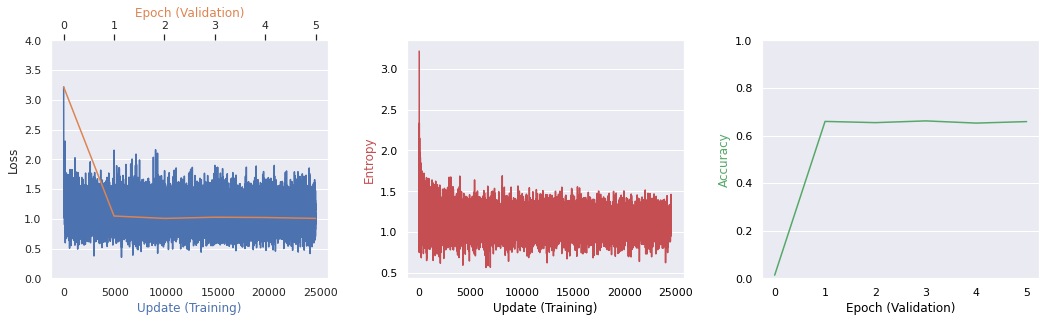

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: " + str(device))

# Specify the google drive mount here if you want to store logs and weights there (and set it up earlier)
logger = Logger("logdir")
print("Saving state to {}".format(logger.basepath))

# Network
net = AgentNetwork(n_units_out=len(train_set.action_mapping))
net = net.to(device)
num_trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print("Trainable Parameters: {}".format(num_trainable_params))

# Loss
loss_func = nn.CrossEntropyLoss().to(device)

# Optimizer
optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Training
val_loss, val_acc = val(net, val_loader, loss_func, logger, 0)
for i_ep in range(n_epochs):
    clear_output(wait=True)
    print("Trainable Parameters: {}".format(num_trainable_params))
    print("Saving state to {}".format(logger.basepath))
    print("[%03d] Validation Loss: %.4f Accuracy: %.4f" % (i_ep, val_loss, val_acc))
    # plot current training state
    if i_ep > 0:
        plot_metrics(logger)
    # train
    sample_frame = train(net, train_loader, loss_func, optimizer, logger, i_ep + 1)
    # validate
    val_loss, val_acc = val(net, val_loader, loss_func, logger, i_ep + 1)
    # store logs
    logger.dump()
    # store weights
    torch.save(net.state_dict(), logger.param_file)

# Export agent as ONNX file
save_as_onnx(net, sample_frame, logger.onnx_file)

# --
clear_output(wait=True)
print("Trainable Parameters: {}".format(num_trainable_params))
print("Saved state to {}".format(logger.basepath))
print("[%03d] Validation Loss: %.4f Accuracy: %.4f" % (i_ep + 1, val_loss, val_acc))
plot_metrics(logger)

# Evaluate the agent in the real environment

### Environment and Agent

Here we create classes for our environment and the agent.

In [13]:
class Env():
    """
    Environment wrapper for CarRacing 
    """

    def __init__(self, img_stack=1, show_hud=True, record_video=True):
        self.record_video=record_video
        self.gym_env = gym.make('CarRacing-v0')
        self.env = self.wrap_env(self.gym_env)
        self.action_space = self.env.action_space
        self.img_stack = img_stack
        self.show_hud = show_hud

    def reset(self, raw_state=False):
        self.env = self.wrap_env(self.gym_env)
        self.rewards = []
        img_rgb = self.env.reset()
        img_gray = rgb2gray(img_rgb)
        if not self.show_hud:
            img_gray = hide_hud(img_gray)
        self.stack = [img_gray] * self.img_stack
        if raw_state:
            return np.array(self.stack), np.array(img_rgb)
        else:
            return np.array(self.stack)

    def step(self, action, raw_state=False):
        img_rgb, reward, done, _ = self.env.step(action)            
        # accumulate reward
        self.rewards.append(reward)            
        # if no reward recently, end the episode
        die = True if np.mean(self.rewards[-np.minimum(100, len(self.rewards)):]) <= -1 else False
        if done or die:
            self.env.close()
        img_gray = rgb2gray(img_rgb)
        if not self.show_hud:
            img_gray = hide_hud(img_gray)
        # add to frame stack  
        self.stack.pop(0)
        self.stack.append(img_gray)
        assert len(self.stack) == self.img_stack
        # --
        if raw_state:
            return np.array(self.stack), np.sum(self.rewards[-1]), done, die, img_rgb
        else:
            return np.array(self.stack), np.sum(self.rewards[-1]), done, die

    def render(self, *arg):
        return self.env.render(*arg)

    def close(self):
        self.env.close()
        
    def wrap_env(self, env):
        if self.record_video:
            env = wrap_env(env)
        return env

class Agent():
    """
    Agent for training
    """
    def __init__(self, net, action_mapping, img_stack=1):
        self.net = net
        self.action_mapping = action_mapping
        self.img_stack = img_stack

    def select_action(self, state):
        state = torch.from_numpy(state).float().to(device).unsqueeze(0)
        with torch.no_grad():
            action_probs = self.net(state)
            if type(action_probs) in (tuple, list):
                action_probs = action_probs[0]            
        action, action_idx, a_logp = self.sample_action(action_probs)
        a_logp = a_logp.item()

        return action, action_idx, a_logp
        
    def sample_action(self, probs):
        m = Categorical(logits=probs.to("cpu"))
        action_idx = m.sample()
        a_logp = m.log_prob(action_idx)
        action = self.action_mapping[int(action_idx.squeeze().cpu().numpy())]
        return action, action_idx, a_logp
    
    def load_param(self, param_file):        
        self.net.load_state_dict(torch.load(param_file))

def run_episode(agent, show_progress=True, record_video=True):
    env = Env(img_stack=1, record_video=record_video)
    state = env.reset()
    score = 0
    done_or_die = False
    if show_progress:
        progress = tqdm(desc="Score: 0")
    while not done_or_die:
        action, action_idx, a_logp = agent.select_action(state)
        state, reward, done, die = env.step(action)
        score += reward
        if show_progress:
            progress.update()
            progress.set_description("Score: {:.2f}".format(score))
        if done or die:
            done_or_die = True
    env.close()
    if show_progress:
        progress.close()    
    if record_video:
        show_video()
    return score

## Evaluate behavioral cloning agent

Let's see how the agent is doing in the real environment

In [14]:
agent = Agent(net, train_set.action_mapping)
agent.load_param(logger.param_file)
print(logger.param_file)
run_episode(agent, show_progress=True, record_video=True);

logdir/2021-04-17T12-14-19/params.pkl
Track generation: 1084..1369 -> 285-tiles track


Since we often have high variance when evaluating RL agents we should evaluate the agent multiple times to get a better feeling for its performance.

In [15]:
n_eval_episodes = 10
scores = []
for i in tqdm(range(n_eval_episodes), desc="Episode"):
    scores.append(run_episode(agent, show_progress=False, record_video=False))
    print("Score: %d" % scores[-1])
print("Mean Score: %.2f (Std: %.2f)" %(np.mean(scores), np.std(scores)))

Track generation: 1095..1373 -> 278-tiles track
Score: 557
Track generation: 1245..1560 -> 315-tiles track
Score: 839
Track generation: 1060..1329 -> 269-tiles track
Score: 608
Track generation: 1139..1428 -> 289-tiles track
Score: 636
Track generation: 1260..1579 -> 319-tiles track
Score: 299
Track generation: 1183..1484 -> 301-tiles track
Score: 449
Track generation: 1007..1263 -> 256-tiles track
Score: 354
Track generation: 1069..1349 -> 280-tiles track
Score: 856
Track generation: 1183..1483 -> 300-tiles track
Score: 374
Track generation: 1100..1379 -> 279-tiles track
Score: 871

Mean Score: 584.90 (Std: 205.31)


# DAGGER

Now we can implement DAgger, you have downloaded a relatively well trained model you can use as an expert for this purpose.

Load expert model that is provided as ONNX file.

## Load the expert

In [17]:
# Load expert
expert_net = ConvertModel(onnx.load("./data/expert.onnx"))
expert_net = expert_net.to(device)
# Freeze expert weights
for p in expert_net.parameters():
    p.requires_grad = False

Next, you have to implement the DAgger algorithm (see slides for details). This function implements the core idea of DAgger:


1. Choose the policy with probability beta
2. Sample T-step trajectories using this policy
3. Label the gathered states with the expert

The aggregation and training part are already implemented.

In [18]:
# inner loop of DAgger
def dagger(current_policy, expert_policy, beta=1.):
    # Set up environment and result lists
    env = Env(img_stack=1, record_video=False)
    state = env.reset()
    # the expert agent was trained using the last 4 frames as input so we need to account for this
    state_log = [state.squeeze()] * 4
    frame_log = []
    action_log = []

    # Use this method to prepare the state for both policies
    def prepare_state_for_policy(policy, state_log):
        return np.array(state_log[-policy.img_stack:])

    #### YOUR CODE HERE ####
    # Implement DAgger algorithm here
    # 1) Choose a policy according to the DAgger algorithm (use beta)
    # 2) Sample trajectory with this policy (here, we create one episode)
    #     -> call "policy.select_action(state)" to predict the action for the current state
    #     -> call "prepare_state_for_policy(policy, state_log)" to get the current state
    #        in the correct format regardless of the chosen policy
    # 3) Label the states of this trajectory with your expert
    #     -> the expert policy always expects 4 frames, pass the state as "np.array(state_log)"

    # 1: Choose policy

    def choose_policy():
        prob = np.random.uniform()
        if prob <= beta:
            return expert_policy
        else:
            return current_policy

    policy = choose_policy()

    done_or_die = False
    while not done_or_die:
        # 2: Sample trajectory:
        #   -> select action
        #   -> perform action in the environment
        #   -> pass "raw_state=True" to env.step() so you can record the 
        #      original frames without pre-processing (which we need to aggregate datasets later)

        #### YOUR CODE HERE ####

        state = prepare_state_for_policy(policy, state_log)
        current_action, action_idx, a_logp = policy.select_action(state)
        state, r, done, die, frame = env.step(current_action, raw_state=True)

        # Always keep the last four frames in the log as we need them for the expert
        state_log.pop(0)
        state_log.append(state.squeeze())

        # 3: label the current state with the expert policy

        #### YOUR CODE HERE ####

        raw_state = np.array(state_log)
        expert_action, action_idx, a_logp = expert_policy.select_action(raw_state)

        # Keep a record of states and actions so we can use them for training our agent
        frame_log.append(frame)
        action_log.append(expert_action)

        # Check when you're done
        if done or die:
            done_or_die = True

    env.close()
    return np.array(frame_log), np.array(action_log)

Now train the agent again using the DAgger algorithm.

In [ ]:
#### YOUR CODE HERE ####
# choose your hyper-parameters
beta = 0.7
learning_rate = 0.001
wight_decay = 0.1
n_epochs = 10
n_dagger_iterations = 100

# Specify the google drive mount here if you want to store logs and weights there (and set it up earlier)
logger = Logger("logdir_dagger")
print("Saving state to {}".format(logger.basepath))

# Re-load datasets (since we change the dataset during DAgger training)
train_set = DemonstrationDataset("./data/train.npz", img_stack=1)
val_set = DemonstrationDataset("./data/val.npz", img_stack=1)
train_loader = DataLoader(train_set, batch_size=batchsize, num_workers=2, shuffle=True, drop_last=False, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=batchsize, num_workers=2, shuffle=False, drop_last=False, pin_memory=True)

# Your own policy network
net = AgentNetwork(n_units_out=len(train_set.action_mapping))
net = net.to(device)

train_agent = Agent(net, train_set.action_mapping, img_stack=1)
expert_agent = Agent(expert_net, train_set.action_mapping, img_stack=4)

# Loss
loss_func = nn.CrossEntropyLoss().to(device)

# Optimizer
optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Training
val_loss, val_acc = val(net, val_loader, loss_func, logger, 0)
for i_ep in range(n_epochs):
    clear_output(wait=True)    
    print("Saving state to {}".format(logger.basepath))
    print("[%03d] Validation Loss: %.4f Accuracy: %.4f" % (i_ep, val_loss, val_acc))
    # create new samples using our expert    
    for _ in tqdm(range(n_dagger_iterations), desc="Generating expert samples"):
        frames, actions = dagger(train_agent, expert_agent, beta=beta)
        # Here we aggregate the datasets by appending the new samples
        # to our training set
        train_set.append(frames, actions)

    # plot current training state
    if i_ep > 0:
        plot_metrics(logger)

    # train the agent on the aggregated dataset
    sample_frame = train(net, train_loader, loss_func, optimizer, logger, i_ep + 1)

    # validate
    val_loss, val_acc = val(net, val_loader, loss_func, logger, i_ep + 1)    

    # store logs
    logger.dump()
    # store weights
    torch.save(net.state_dict(), logger.param_file)

# store the dagger agent
save_as_onnx(net, sample_frame, logger.onnx_file)
# --
clear_output(wait=True)
print("Saved state to {}".format(logger.basepath))
print("[%03d] Validation Loss: %.4f Accuracy: %.4f" % (i_ep + 1, val_loss, val_acc))
plot_metrics(logger)

Saving state to logdir_dagger/2021-04-17T12-18-10
[007] Validation Loss: 1.1060 Accuracy: 0.6367


Track generation: 1220..1529 -> 309-tiles track
Track generation: 1225..1535 -> 310-tiles track
Track generation: 1100..1379 -> 279-tiles track
Track generation: 1208..1514 -> 306-tiles track
Track generation: 1059..1328 -> 269-tiles track
Track generation: 1200..1504 -> 304-tiles track
Track generation: 1259..1586 -> 327-tiles track
Track generation: 1186..1489 -> 303-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 987..1242 -> 255-tiles track
Track generation: 1101..1380 -> 279-tiles track
Track generation: 1076..1349 -> 273-tiles track
Track generation: 1169..1466 -> 297-tiles track
Track generation: 1163..1458 -> 295-tiles track
Track generation: 1164..1467 -> 303-tiles track
Track generation: 1037..1302 -> 265-tiles track
Track generation: 1052..1319 -> 267-tiles track
Track generation: 1239..1553 -> 314-tiles track
Track generation: 1149..1440 -> 291-tiles track
Track generation: 1203..1508 -> 305-tiles track
Track gen

## Evaluate DAgger Agent 

If you successfully implemented your agent and the DAgger algorithm you can now upload your submission.

First, lets check how the agent performs.

In [20]:
run_episode(train_agent, show_progress=True, record_video=True);

Track generation: 1167..1463 -> 296-tiles track


In [21]:
n_eval_episodes = 10
scores = []
for i in tqdm(range(n_eval_episodes), desc="Episode"):
    scores.append(run_episode(train_agent, show_progress=False, record_video=False))
    print("Score: %d" % scores[-1])
print("Mean Score: %.2f (Std: %.2f)" %(np.mean(scores), np.std(scores)))

Track generation: 1175..1473 -> 298-tiles track
Score: 300
Track generation: 1240..1554 -> 314-tiles track
Score: 443
Track generation: 1013..1278 -> 265-tiles track
Score: 566
Track generation: 1116..1399 -> 283-tiles track
Score: 850
Track generation: 1237..1551 -> 314-tiles track
Score: 423
Track generation: 1171..1472 -> 301-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1052..1329 -> 277-tiles track
Score: 55
Track generation: 1100..1379 -> 279-tiles track
Score: 680
Track generation: 1139..1428 -> 289-tiles track
Score: 535
Track generation: 1190..1492 -> 302-tiles track
Score: 262
Track generation: 1143..1433 -> 290-tiles track
Score: 699

Mean Score: 481.80 (Std: 223.63)
